### Alternative approach using SVM

In [1]:
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
start = time.time()
npzfile = np.load('HCS_48x48.npz')
print ("Loaded data in " + str(time.time() - start))

Loaded data in 0.00041389465332


In [3]:
npzfile.files

['arr_1', 'arr_0', 'arr_2']

In [4]:
start = time.time()
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))

Loaded data in 4.46041202545


In [5]:
np.shape(cell_rows), np.shape(Y), np.shape(X), type(X)

((52950,), (52950,), (52950, 5, 48, 48), numpy.ndarray)

### Loading the features of the cells

In [6]:
cells = pd.read_csv('/home/dueo/data/Genedata/Cells.csv')

In [7]:
cells[0:10]

,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Compound,Metadata_FileLocation,Metadata_Frame,Metadata_Phenotype,Metadata_Plate,Metadata_Series,Metadata_Site,...,Texture_Variance_ER_3_0,Texture_Variance_ER_5_0,Texture_Variance_Golgi_Actin_3_0,Texture_Variance_Golgi_Actin_5_0,Texture_Variance_Hoechst_3_0,Texture_Variance_Hoechst_5_0,Texture_Variance_Mito_3_0,Texture_Variance_Mito_5_0,Texture_Variance_Nucleoli_3_0,Texture_Variance_Nucleoli_5_0
0,1,1,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.963408,0.942669,1.432731,1.470543,2.608476,2.653153,1.357492,1.328036,1.516640,1.495042
1,1,2,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.070573,1.084703,1.917686,1.915602,2.261544,2.322472,1.621720,1.628327,1.489087,1.491358
2,1,3,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.703105,0.714262,1.621151,1.623899,1.664106,1.705266,1.610848,1.621337,1.679954,1.700747
3,1,4,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.878495,0.893629,2.028432,2.033459,1.902903,1.943207,1.805773,1.814701,2.316864,2.325391
4,1,5,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.316787,1.330969,1.780373,1.792182,1.583360,1.619792,2.144978,2.150522,2.188546,2.206693
5,1,6,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.539576,0.547029,0.619443,0.621007,1.200822,1.226364,0.830376,0.833998,1.662265,1.674101
6,1,7,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,0.963023,0.979858,1.829875,1.830180,1.448971,1.480549,1.988062,2.009791,2.049452,2.074722
7,1,8,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.615376,1.670367,1.025157,1.044319,1.195368,1.233132,1.294517,1.335664,1.401528,1.434296
8,1,9,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.541733,1.560041,1.994704,1.990997,2.043194,2.106477,2.605194,2.634599,2.202151,2.215279
9,1,10,NaN,PACLITAXEL,NaN,0,1,20585,0,1,...,1.178213,1.190568,1.406871,1.418717,1.183611,1.203218,1.903699,1.914429,1.672578,1.693390


### Extracting the features and imputing NaNs

In [8]:
X_features = np.asmatrix(cells.ix[cell_rows,11:])
np.shape(X_features)

(52950, 396)

In [9]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_features)
X_features = imp.transform(X_features)

### Normalization

In [10]:
Xmean = X_features.mean(axis = 0)
XStd = np.sqrt(X_features.var(axis=0))
X = (X_features-Xmean)/(XStd + 0.1)

In [11]:
np.max(X[:,1])

1.8164506533032305

In [12]:
np.min(X), np.max(X), np.mean(X)

(-9.5833446880979825, 132.67998438665234, -2.6729815147106906e-18)

In [13]:
Y = np.asarray(Y,dtype='int32')

### Some examples (after normalization)
rows are the different compounds

### Splitting in training and test-set



#### Version 2
80%, 20% randomly choosen

In [14]:
# Currently a Acc. of 0.8976
np.random.seed(seed=42)
perm1 = np.random.permutation(len(Y))
print('Sum of permutation {0}'.format(np.sum(perm1))) #1401824775
N_split = int(len(Y) * 0.8)
N_split
idx_train  = perm1[:N_split]
idx_test  = perm1[N_split:]
    

X_train = X[idx_train,:]
Y_train = Y[idx_train]
X_test = X[idx_test,:]
Y_test = Y[idx_test]

Sum of permutation 1401824775


#### Permuting the training set

In [15]:
perm = np.random.permutation(len(Y_train))
XX = X_train[perm,:]
YY = Y_train[perm]

### 10 Fold X-Validation

We use a 10 fold crossvalidation on the training set to find the optimal parameters

### Sampling 

For the SVM we sample so that the classes have equal proportions.

In [65]:
hist = np.histogram(YY, bins=[0, 1, 2, 3,4])
NMAX = np.min(hist[0])
hist, NMAX

((array([32566,  1585,  7877,   332]), array([0, 1, 2, 3, 4])), 332)

In [66]:
idx3 = np.argwhere(YY == 3)[0:NMAX]
idx2 = np.argwhere(YY == 2)[0:NMAX]
idx1 = np.argwhere(YY == 1)[0:NMAX]
idx0 = np.argwhere(YY == 0)[0:NMAX]
idx_d = np.concatenate((idx0,idx1,idx2,idx3))[:,0] #Orderedness is problem in studip k-fold
perm_d = np.random.permutation(len(idx_d))
idx = idx_d[perm_d]

In [67]:
XX1 = XX[idx]
YY1 = YY[idx]
np.shape(XX1), np.shape(YY1),np.shape(XX),np.shape(idx)

((1328, 396), (1328,), (42360, 396), (1328,))

In [68]:
np.histogram(YY1,  bins=[0, 1, 2, 3,4])

(array([332, 332, 332, 332]), array([0, 1, 2, 3, 4]))

In [69]:
YY1[1:10]

array([0, 0, 2, 0, 3, 2, 0, 1, 0], dtype=int32)

In [70]:
def eval_10_Fold(C = 0.5):
    N = len(XX1)
    kf = KFold(N, n_folds=10)
    acc = 0.0
    rounds = 0.0
    for train, test in kf:
        model = svm.SVC(kernel='linear', C=C).fit(XX1[train,],YY1[train])
        res = model.predict(XX1[test])
        acc += sum(res == YY1[test])/float(len(test)) #Accuracy
        rounds += 1.0
        print('round ={0} C={1} acc (cumulated over the faults) ={2}'.format(rounds, C, acc / rounds))
    return acc

In [71]:
Cs = (1e-3,5e-3,1e-2,5e-2,1e-1,1e0,1e+1,1e2,1e3)
res = np.zeros(len(Cs))
for i,C in enumerate(Cs):
    res[i] = eval_10_Fold(C)

round =1.0 C=0.001 acc (cumulated over the faults) =0.774436090226
round =2.0 C=0.001 acc (cumulated over the faults) =0.796992481203
round =3.0 C=0.001 acc (cumulated over the faults) =0.80701754386
round =4.0 C=0.001 acc (cumulated over the faults) =0.81954887218
round =5.0 C=0.001 acc (cumulated over the faults) =0.816541353383
round =6.0 C=0.001 acc (cumulated over the faults) =0.81328320802
round =7.0 C=0.001 acc (cumulated over the faults) =0.817400644468
round =8.0 C=0.001 acc (cumulated over the faults) =0.812030075188
round =9.0 C=0.001 acc (cumulated over the faults) =0.811030100504
round =10.0 C=0.001 acc (cumulated over the faults) =0.807199817726
round =1.0 C=0.005 acc (cumulated over the faults) =0.812030075188
round =2.0 C=0.005 acc (cumulated over the faults) =0.845864661654
round =3.0 C=0.005 acc (cumulated over the faults) =0.847117794486
round =4.0 C=0.005 acc (cumulated over the faults) =0.851503759398
round =5.0 C=0.005 acc (cumulated over the faults) =0.8556390977

((0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0, 1000.0),
 array([ 8.07199818,  8.40328093,  8.56168831,  8.62952837,  8.63710412,
         8.47157667,  8.14781271,  8.01224653,  7.98969013]))

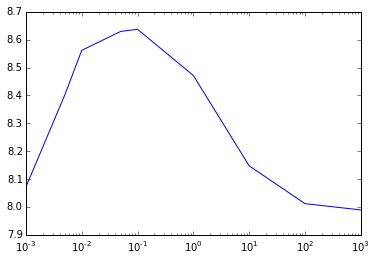

In [78]:
plt.semilogx(Cs,res)
(Cs,res)

### Evaluation on the test set

Training the model on the whole training data set

In [79]:
model = svm.SVC(kernel='linear', C=0.1).fit(XX1,YY1)

In [82]:
pred = model.predict(X_test)

In [83]:
sum(pred == Y_test)/float(len(Y_test))

0.82492917847025493

### Calucation of the confusion matrix

In [87]:
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,6898,9,388,0
PACLITAXEL Pred,61,369,112,0
METOCLOPRAMIDE Pred,1224,16,1387,0
DIGOXIN Pred,34,9,1,82


In [88]:
#cm_normalized = m.astype('float') / ((m.sum(axis=1)[:, np.newaxis]))
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:]))
print('Normalized confusion matrix')
pd.DataFrame(cm_normalized)

Normalized confusion matrix


,0,1,2,3
0,0.839479,0.022333,0.205508,0
1,0.007424,0.915633,0.059322,0
2,0.148959,0.039702,0.734640,0
3,0.004138,0.022333,0.000530,1


In [89]:
np.mean(cm_normalized[np.diag_indices(4)])

0.87243792837166534